In [1]:
from all_imports import *

In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML

from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))

import time

In [3]:
SEED=42
random.seed(SEED)
torch.manual_seed(SEED)
# Batch size during training
batch_size = 256
# Spatial size of training images. All images will be resized to this size using a transformer.
# image_size = 32 # not used
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 32
# Number of training epochs
# num_epochs = 100 <- defined in training loop
# different Learning rate for optimizers
g_lr = 0.001
d_lr = 0.0004
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
ngpu=1

In [4]:
TRAIN_PATH = "./trafic_32"

In [5]:
transform = transforms.Compose([
                                # transforms.Resize(image_size),
                                transforms.ToTensor()])

trainFolder = torchvision.datasets.ImageFolder(root=TRAIN_PATH,
                                               transform=transform)

dataset = trainFolder

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True)

In [6]:
device = torch.device('mps')

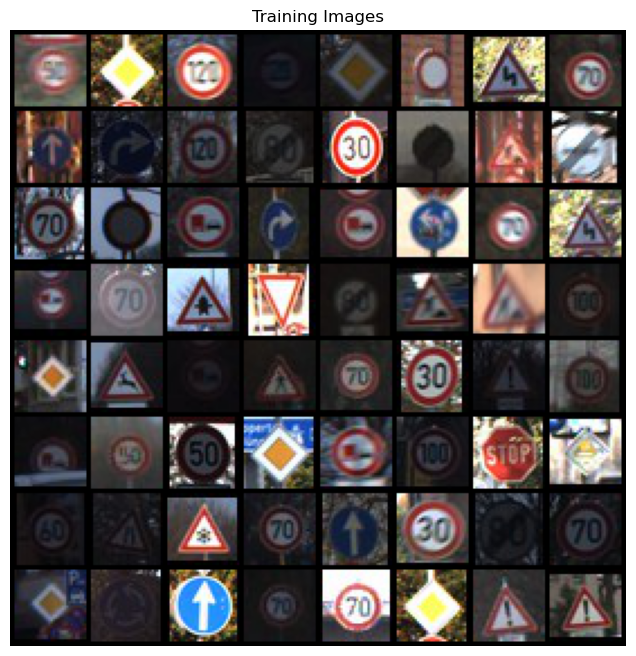

In [7]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].cpu()[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Model

## Generator

Changed:
<!-- - kernel size 4 -> 2 -->

In [8]:
GENERATOR_KERNEL_SIZE = 4

In [9]:
# # 64x64 image version
# class Generator(nn.Module):
#     def __init__(self, ngpu):
#         super(Generator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d( nz, ngf * 8, GENERATOR_KERNEL_SIZE, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, GENERATOR_KERNEL_SIZE, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d( ngf * 4, ngf * 2, GENERATOR_KERNEL_SIZE, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf * 2, ngf, GENERATOR_KERNEL_SIZE, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             nn.ConvTranspose2d( ngf, nc, GENERATOR_KERNEL_SIZE, 2, 1, bias=False),
#             nn.Tanh()
#             # state size. (nc) x 64 x 64
#         )

#     def forward(self, input):
#         return self.main(input)

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, GENERATOR_KERNEL_SIZE, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, GENERATOR_KERNEL_SIZE, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, GENERATOR_KERNEL_SIZE, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, nc, GENERATOR_KERNEL_SIZE, 2, 1, bias=False),
            nn.Tanh()
            # state size. (ngc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


## Discriminator

In [13]:
# # 64x64 image version
# class Discriminator(nn.Module):
#     def __init__(self, ngpu):
#         super(Discriminator, self).__init__()
#         self.ngpu = ngpu
#         self.main = nn.Sequential(
#             # input is (nc) x 64 x 64
#             nn.Conv2d(nc, ndf, DISCRIMINATOR_KERNEL_SIZE, DISCRIMINATOR_STRIDE, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 32 x 32
#             nn.Conv2d(ndf, ndf * 2, DISCRIMINATOR_KERNEL_SIZE, DISCRIMINATOR_STRIDE, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(ndf * 2, ndf * 4, DISCRIMINATOR_KERNEL_SIZE, DISCRIMINATOR_STRIDE, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(ndf * 4, ndf * 8, DISCRIMINATOR_KERNEL_SIZE, DISCRIMINATOR_STRIDE, 1, bias=False),
#             nn.BatchNorm2d(ndf * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 4 x 4
#             nn.Conv2d(ndf * 8, 1, DISCRIMINATOR_KERNEL_SIZE, DISCRIMINATOR_STRIDE-1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)


In [16]:
# Initialize BCELoss function
criterion = nn.BCELoss()
# Establish convention for real and fake labels during training
# real_label = 1
# fake_label = 0
"""adding label smoothing"""
real_label=0.9
fake_label=0.1

# Setup Adam optimizers for both G and D

optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))

# FID (Frechet Inception Distance)

In [17]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [18]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [19]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=False)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=False)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [20]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.to(device)

/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Number of parameters

In [21]:
print("Generator Parameters:",sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator Parameters:",sum(p.numel() for p in netD.parameters() if p.requires_grad))

Generator Parameters: 3448576
Discriminator Parameters: 691584


# Training loop

Starting Training Loop...
[1/40]	Loss_D: 0.8012	Loss_G: 2.3716	Fretchet_Distance: 143.5573


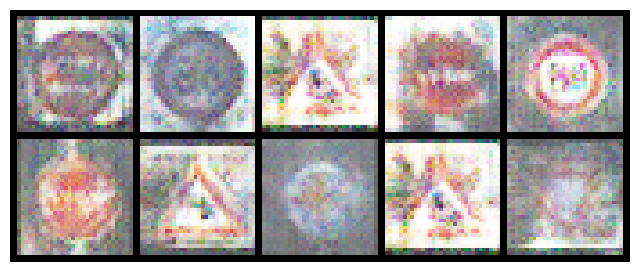

[2/40]	Loss_D: 0.6769	Loss_G: 2.9071	Fretchet_Distance: 141.4557


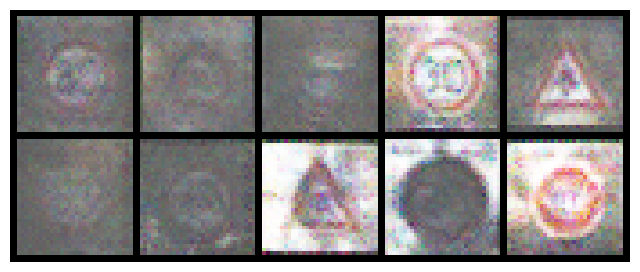

[3/40]	Loss_D: 0.6997	Loss_G: 2.6124	Fretchet_Distance: 136.9521


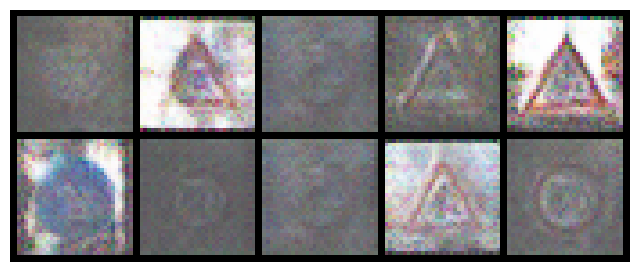

[4/40]	Loss_D: 0.6802	Loss_G: 2.0590	Fretchet_Distance: 135.4771


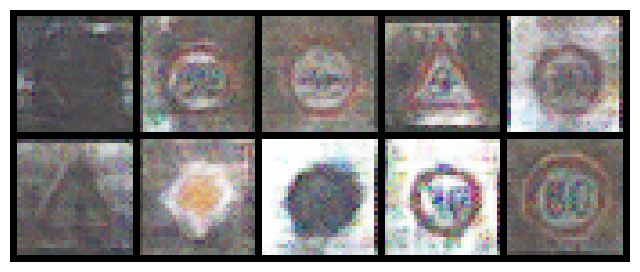

[5/40]	Loss_D: 0.6770	Loss_G: 2.6033	Fretchet_Distance: 144.2741


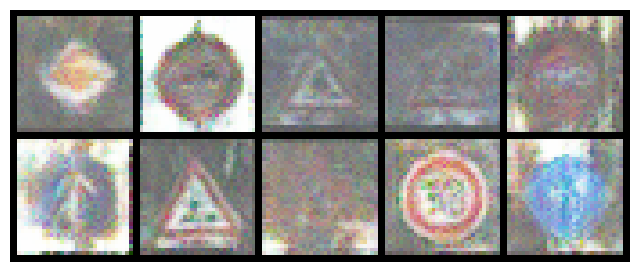

[6/40]	Loss_D: 1.1183	Loss_G: 0.7364	Fretchet_Distance: 135.1701


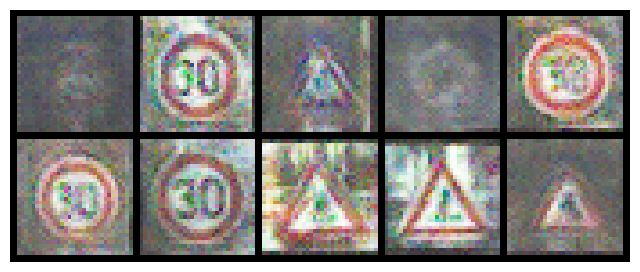

[7/40]	Loss_D: 0.7262	Loss_G: 3.1917	Fretchet_Distance: 137.9564


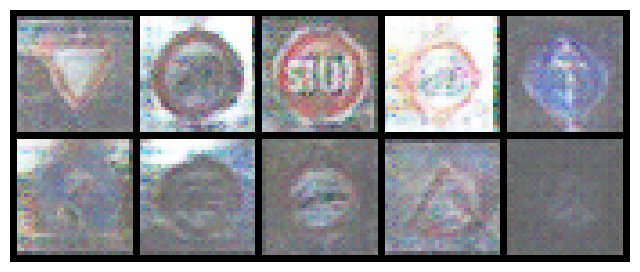

[8/40]	Loss_D: 0.7270	Loss_G: 2.9239	Fretchet_Distance: 138.7186


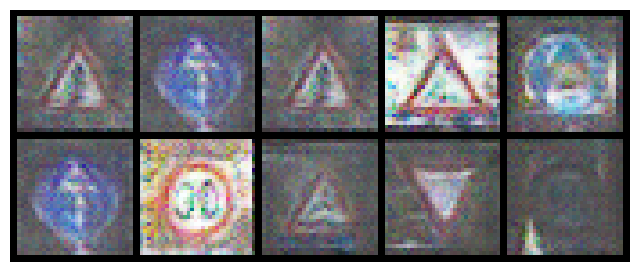

[9/40]	Loss_D: 0.7776	Loss_G: 4.0308	Fretchet_Distance: 132.3340


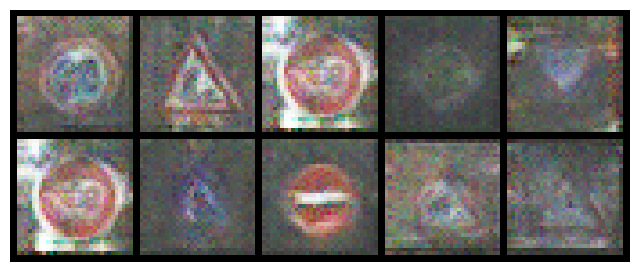

[10/40]	Loss_D: 0.6759	Loss_G: 2.4752	Fretchet_Distance: 146.7778


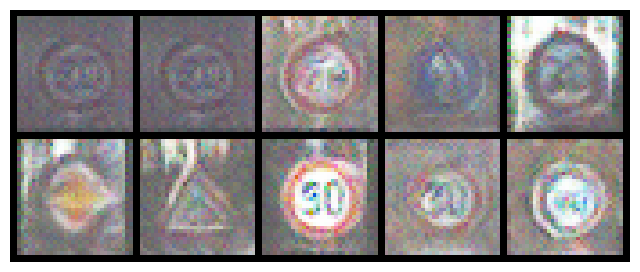

[11/40]	Loss_D: 0.7710	Loss_G: 2.4034	Fretchet_Distance: 119.9896


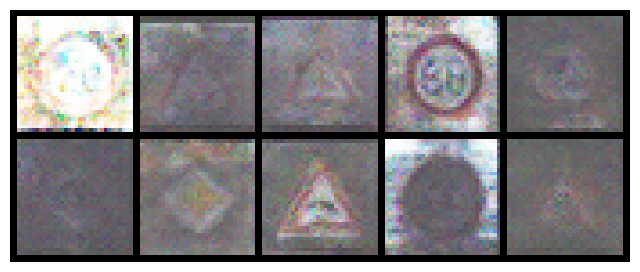

[12/40]	Loss_D: 0.6688	Loss_G: 2.0696	Fretchet_Distance: 128.2888


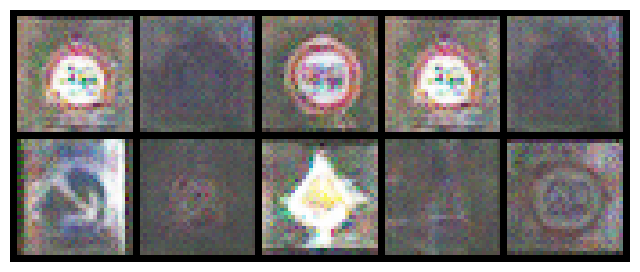

[13/40]	Loss_D: 1.0730	Loss_G: 6.1253	Fretchet_Distance: 134.7953


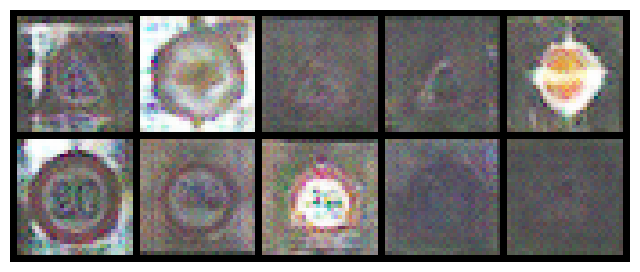

[14/40]	Loss_D: 0.6928	Loss_G: 2.5742	Fretchet_Distance: 123.5572


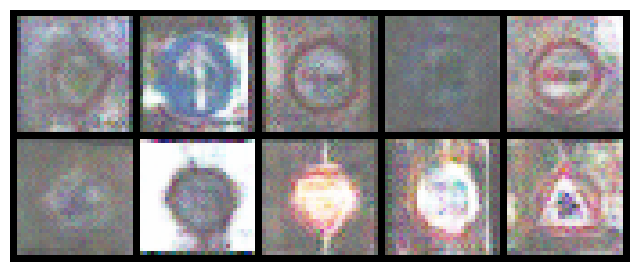

[15/40]	Loss_D: 0.9749	Loss_G: 1.0938	Fretchet_Distance: 142.4832


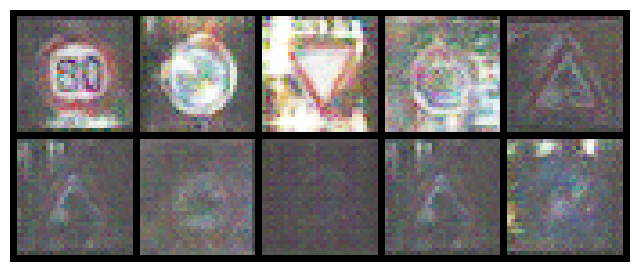

KeyboardInterrupt: 

In [25]:
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 40

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
#         # add some noise to the input to discriminator
        
        real_cpu=0.9*real_cpu+0.1*torch.randn((real_cpu.size()), device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        fake=0.9*fake+0.1*torch.randn((fake.size()), device=device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()
        
        # Calculate gradients for G
        errG.backward()
        # Update G
        optimizerG.step()
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fixed_noise = torch.randn(ngf, nz, 1, 1, device=device)
                fake_display = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))
            
         
            
        iters += 1   
    G_losses.append(errG.item())
    D_losses.append(errD.item())     
    fretchet_dist=calculate_fretchet(real_cpu,fake,model) 
    if ((epoch+1)%1==0):
        
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tFretchet_Distance: %.4f'
                      % (epoch+1, num_epochs,
                         errD.item(), errG.item(),fretchet_dist))
        
        
        plt.figure(figsize=(8,8))
        plt.axis("off")
        pictures=vutils.make_grid(fake_display[torch.randint(len(fake_display), (10,))],nrow=5,padding=2, normalize=True)
        plt.imshow(np.transpose(pictures,(1,2,0)))
        plt.show()

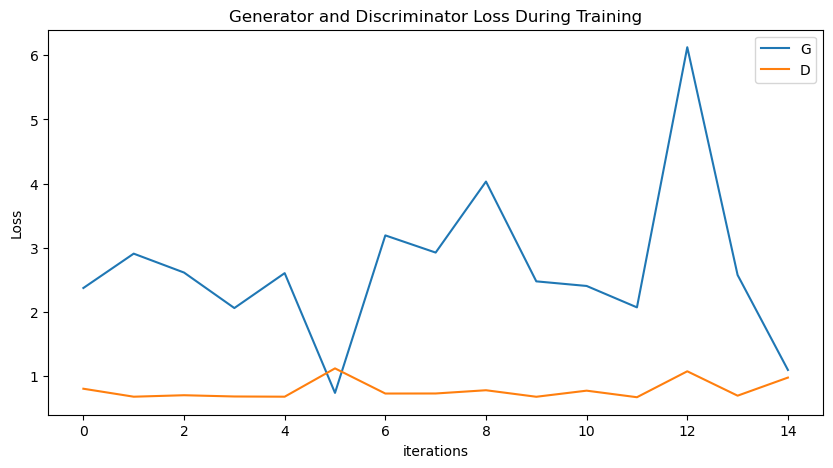

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

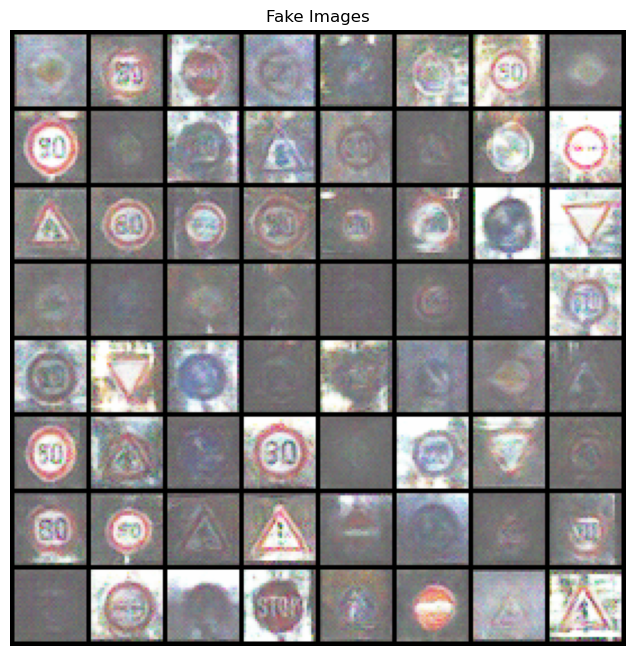

In [27]:
# Plot genearted images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()